In [1]:
import os
# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.4.0'
spark_version = 'spark-3.4.4'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Fetched 384 kB in 2s (198 kB/s)
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [2]:
# Import packages
from pyspark.sql import SparkSession
import time

# Create a SparkSession
spark = SparkSession.builder.appName("SparkSQL").getOrCreate()

In [3]:
# Read in data from S3 Bucket
import pandas as pd
from pyspark.sql import SparkSession

# Initialize SparkSession
spark = SparkSession.builder \
    .appName("NYC Taxi Data Analysis") \
    .getOrCreate()

# URL of the CSV file
data_url = "https://project4-nyctaxi.s3.us-east-1.amazonaws.com/train.csv"

# Download the file using Pandas
local_file = "train.csv"
pd.read_csv(data_url).to_csv(local_file, index=False)

# Read the local file into a Spark DataFrame
df = spark.read.csv(local_file, header=True, inferSchema=True)

# Show the DataFrame
df.show()

+---------+---------+-------------------+-------------------+---------------+------------------+------------------+------------------+------------------+------------------+-------------+
|       id|vendor_id|    pickup_datetime|   dropoff_datetime|passenger_count|  pickup_longitude|   pickup_latitude| dropoff_longitude|  dropoff_latitude|store_and_fwd_flag|trip_duration|
+---------+---------+-------------------+-------------------+---------------+------------------+------------------+------------------+------------------+------------------+-------------+
|id2875421|        2|2016-03-14 17:24:55|2016-03-14 17:32:30|              1|-73.98215484619139| 40.76793670654297|-73.96463012695312|40.765602111816406|                 N|          455|
|id2377394|        1|2016-06-12 00:43:35|2016-06-12 00:54:38|              1|-73.98041534423827|40.738563537597656|-73.99948120117188|40.731151580810554|                 N|          663|
|id3858529|        2|2016-01-19 11:35:24|2016-01-19 12:10:48|    

In [ ]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np


In [ ]:
from pyspark.sql.functions import col, hour, dayofmonth, dayofweek, to_timestamp

# Convert pickup_datetime to a timestamp
df = df.withColumn('pickup_datetime', to_timestamp(col('pickup_datetime')))

# Extract time-based features
df = df.withColumn('pickup_hour', hour(col('pickup_datetime')))
df = df.withColumn('pickup_day', dayofmonth(col('pickup_datetime')))
df = df.withColumn('pickup_weekday', dayofweek(col('pickup_datetime')))

# Show the updated DataFrame
df.show()


+---------+---------+-------------------+-------------------+---------------+------------------+------------------+------------------+------------------+------------------+-------------+-----------+----------+--------------+
|       id|vendor_id|    pickup_datetime|   dropoff_datetime|passenger_count|  pickup_longitude|   pickup_latitude| dropoff_longitude|  dropoff_latitude|store_and_fwd_flag|trip_duration|pickup_hour|pickup_day|pickup_weekday|
+---------+---------+-------------------+-------------------+---------------+------------------+------------------+------------------+------------------+------------------+-------------+-----------+----------+--------------+
|id2875421|        2|2016-03-14 17:24:55|2016-03-14 17:32:30|              1|-73.98215484619139| 40.76793670654297|-73.96463012695312|40.765602111816406|                 N|          455|         17|        14|             2|
|id2377394|        1|2016-06-12 00:43:35|2016-06-12 00:54:38|              1|-73.98041534423827|40.7

In [ ]:
# Define features (X) and target (y)
X = df.drop('trip_duration')
y = df.select('trip_duration')


In [ ]:
# Split the dataset into training and testing sets
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

In [ ]:
from pyspark.sql.functions import col
from pyspark.sql.types import TimestampType


In [ ]:
train_data = train_data.withColumn('pickup_datetime', col('pickup_datetime').cast('timestamp'))
test_data = test_data.withColumn('pickup_datetime', col('pickup_datetime').cast('timestamp'))


In [ ]:
from pyspark.ml.regression import RandomForestRegressor

# Define the Random Forest model with the correct parameters
rf = RandomForestRegressor(featuresCol='features', labelCol='trip_duration', numTrees=100)

In [ ]:
train_data.printSchema()


root
 |-- id: string (nullable = true)
 |-- vendor_id: integer (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- trip_duration: integer (nullable = true)
 |-- pickup_hour: integer (nullable = true)
 |-- pickup_day: integer (nullable = true)
 |-- pickup_weekday: integer (nullable = true)



In [ ]:
from pyspark.ml.feature import VectorAssembler

# Assemble features
feature_columns = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude',
                   'dropoff_longitude', 'pickup_hour', 'pickup_day', 'pickup_weekday']
assembler = VectorAssembler(inputCols=feature_columns, outputCol='features')

In [ ]:
from pyspark.sql.functions import col

# List of feature columns to cast
numeric_columns = ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude']


In [ ]:
# Cast each column to double
for column in numeric_columns:
    train_data = train_data.withColumn(column, col(column).cast('double'))
    test_data = test_data.withColumn(column, col(column).cast('double'))

In [ ]:
# Transform the train and test datasets
train_data = assembler.transform(train_data).select('features', 'trip_duration')
test_data = assembler.transform(test_data).select('features', 'trip_duration')

In [ ]:
train_data.select('features', 'trip_duration').show(5, truncate=False)


+------------------------------------------------------------------------------------------+-------------+
|features                                                                                  |trip_duration|
+------------------------------------------------------------------------------------------+-------------+
|[40.72476196289063,-74.00962829589844,40.71548461914063,-74.015869140625,9.0,15.0,4.0]    |303          |
|[40.765926361083984,-73.96918487548828,40.76223373413086,-73.98165893554686,22.0,4.0,6.0] |256          |
|[40.780948638916016,-73.98369598388672,40.764175415039055,-73.95437622070312,9.0,17.0,3.0]|1939         |
|[40.742225646972656,-74.00420379638672,40.75182342529297,-73.9945068359375,3.0,13.0,1.0]  |297          |
|[40.817779541015625,-73.9420623779297,40.64738845825195,-73.7889175415039,4.0,28.0,7.0]   |1620         |
+------------------------------------------------------------------------------------------+-------------+
only showing top 5 rows



In [ ]:
from pyspark.sql.functions import col

# Cast trip_duration as double
train_data = train_data.withColumn('trip_duration', col('trip_duration').cast('double'))
test_data = test_data.withColumn('trip_duration', col('trip_duration').cast('double'))

In [ ]:
model = rf.fit(train_data)


In [ ]:
# Make Predictions
predictions = model.transform(test_data)

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

# Evaluate the Model
evaluator = RegressionEvaluator(labelCol='trip_duration', predictionCol='prediction', metricName='rmse')
rmse = evaluator.evaluate(predictions)
mae = evaluator.evaluate(predictions, {evaluator.metricName: "mae"})

In [ ]:
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")


Root Mean Squared Error (RMSE): 3119.1276756613697
Mean Absolute Error (MAE): 505.86142623454435


In [ ]:
import matplotlib.pyplot as plt

# Convert predictions to pandas for visualization
predictions_pandas = predictions.select('trip_duration', 'prediction').toPandas()
predictions_pandas.head()

,trip_duration,prediction
0,427.0,813.353015
1,225.0,818.663492
2,564.0,819.469303
3,2531.0,1872.404963
4,319.0,821.748299


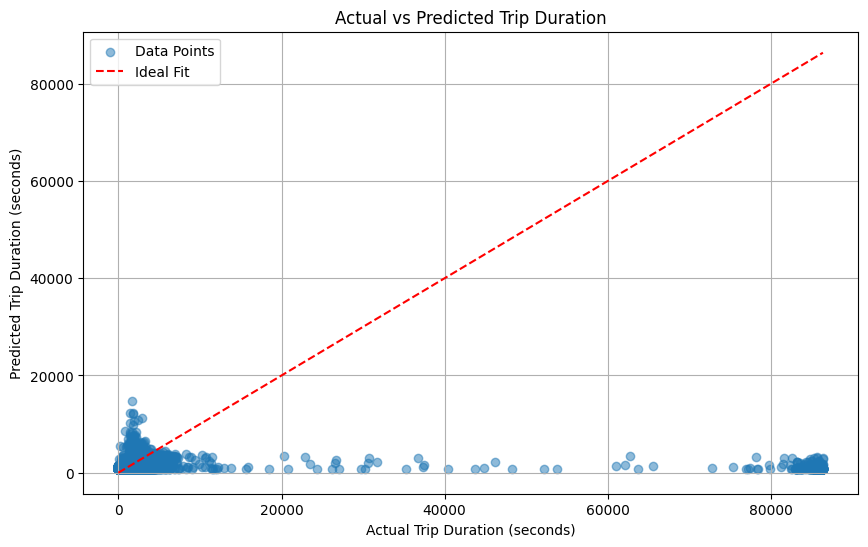

In [ ]:
# Plot Actual vs. Predicted trip duration
plt.figure(figsize=(10, 6))
plt.scatter(predictions_pandas['trip_duration'], predictions_pandas['prediction'], alpha=0.5, label='Data Points')
plt.plot([0, predictions_pandas['trip_duration'].max()],
         [0, predictions_pandas['trip_duration'].max()], color='red', linestyle='--', label='Ideal Fit')
plt.title('Actual vs Predicted Trip Duration')
plt.xlabel('Actual Trip Duration (seconds)')
plt.ylabel('Predicted Trip Duration (seconds)')
plt.legend()
plt.grid()
plt.show()

In [ ]:
from pyspark.ml.regression import LinearRegression

# Define the Linear Regression model
lr = LinearRegression(featuresCol='features', labelCol='trip_duration')

In [ ]:
# Train the model
linear_model = lr.fit(train_data)

In [ ]:
# Make predictions
linear_predictions = linear_model.transform(test_data)

In [ ]:
# Evaluate the model
lr_rmse = evaluator.evaluate(linear_predictions)
lr_mae = evaluator.evaluate(linear_predictions, {evaluator.metricName: "mae"})

print(f"Linear Regression - Root Mean Squared Error (RMSE): {lr_rmse}")
print(f"Linear Regression - Mean Absolute Error (MAE): {lr_mae}")

Linear Regression - Root Mean Squared Error (RMSE): 3147.113573166716
Linear Regression - Mean Absolute Error (MAE): 592.9455930033218


In [ ]:
linear_predictions.show()


+--------------------+-------------+------------------+
|            features|trip_duration|        prediction|
+--------------------+-------------+------------------+
|[40.7637863159179...|        427.0| 940.7123599908664|
|[40.7304382324218...|        225.0| 991.0200288758497|
|[40.7422790527343...|        564.0| 985.2501915977336|
|[40.7617492675781...|       2531.0|1024.8802439430729|
|[40.7498016357421...|        319.0| 916.5044748937944|
|[40.7627754211425...|       1084.0| 876.8405412035645|
|[40.7459564208984...|        443.0| 978.2553961175727|
|[40.7359199523925...|       1792.0| 943.1352065388928|
|[40.7404937744140...|        283.0|  891.547353283444|
|[40.7552490234375...|        844.0| 858.8546783927013|
|[40.7805709838867...|        282.0| 883.7724301655544|
|[40.7388381958007...|        313.0| 990.9939815672697|
|[40.7369041442871...|       1096.0|1020.1594477623003|
|[40.7702102661132...|       1643.0|  738.992764371098|
|[40.7288513183593...|        146.0|1043.6748038

In [ ]:
# Convert Spark DataFrame to Pandas for easy manipulation
linear_predictions_pandas = linear_predictions.select("trip_duration", "prediction").toPandas()

In [ ]:
# Extract actual and predicted values
actual = linear_predictions_pandas["trip_duration"]
predicted = linear_predictions_pandas["prediction"]

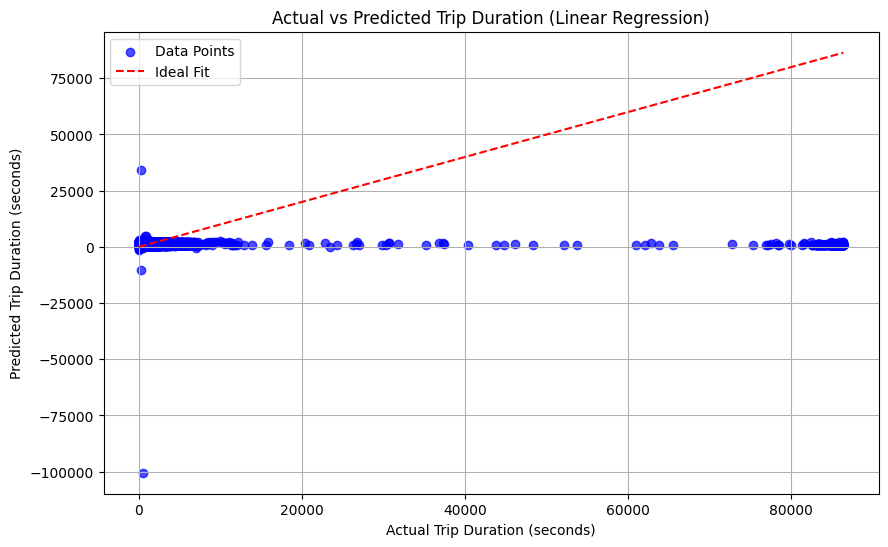

In [ ]:
# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(actual, predicted, label="Data Points", alpha=0.7, color='blue')
plt.plot([actual.min(), actual.max()], [actual.min(), actual.max()], color="red", linestyle="--", label="Ideal Fit")

plt.xlabel("Actual Trip Duration (seconds)")
plt.ylabel("Predicted Trip Duration (seconds)")
plt.title("Actual vs Predicted Trip Duration (Linear Regression)")
plt.legend()
plt.grid(True)
plt.show()

          id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.765602                  N            455  
1         40.731

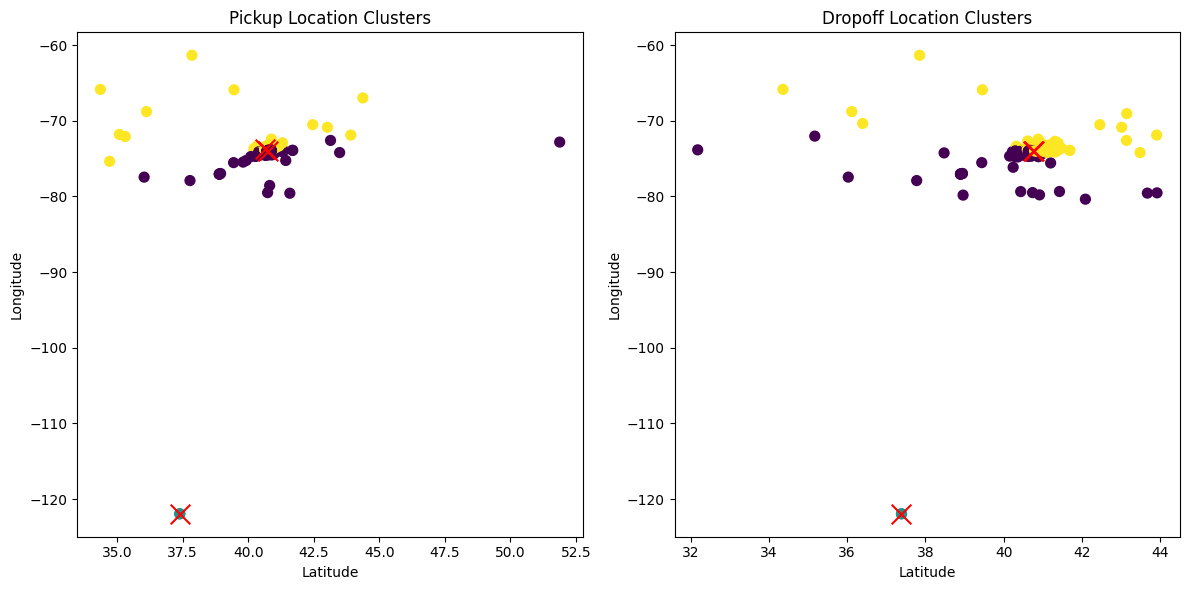

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# URL for the dataset
url = "https://project4-nyctaxi.s3.us-east-1.amazonaws.com/train.csv"

# Load the dataset into a Pandas DataFrame
df = pd.read_csv(url)

# Display the first few rows of the dataframe
print(df.head())

# Extract coordinates for clustering
pickup_coords = df[['pickup_latitude', 'pickup_longitude']].to_numpy()
dropoff_coords = df[['dropoff_latitude', 'dropoff_longitude']].to_numpy()

# K-means clustering
n_clusters = 3  # Number of clusters
kmeans_pickup = KMeans(n_clusters=n_clusters, random_state=42).fit(pickup_coords)
kmeans_dropoff = KMeans(n_clusters=n_clusters, random_state=42).fit(dropoff_coords)

# Add cluster labels back to the dataframe
df['pickup_cluster'] = kmeans_pickup.labels_
df['dropoff_cluster'] = kmeans_dropoff.labels_

# Visualize the clusters
plt.figure(figsize=(12, 6))

# Plot pickup clusters
plt.subplot(1, 2, 1)
plt.scatter(pickup_coords[:, 0], pickup_coords[:, 1], c=kmeans_pickup.labels_, cmap='viridis', s=50)
plt.scatter(kmeans_pickup.cluster_centers_[:, 0], kmeans_pickup.cluster_centers_[:, 1], color='red', marker='x', s=200)
plt.title('Pickup Location Clusters')
plt.xlabel('Latitude')
plt.ylabel('Longitude')

# Plot dropoff clusters
plt.subplot(1, 2, 2)
plt.scatter(dropoff_coords[:, 0], dropoff_coords[:, 1], c=kmeans_dropoff.labels_, cmap='viridis', s=50)
plt.scatter(kmeans_dropoff.cluster_centers_[:, 0], kmeans_dropoff.cluster_centers_[:, 1], color='red', marker='x', s=200)
plt.title('Dropoff Location Clusters')
plt.xlabel('Latitude')
plt.ylabel('Longitude')

plt.tight_layout()
plt.show()


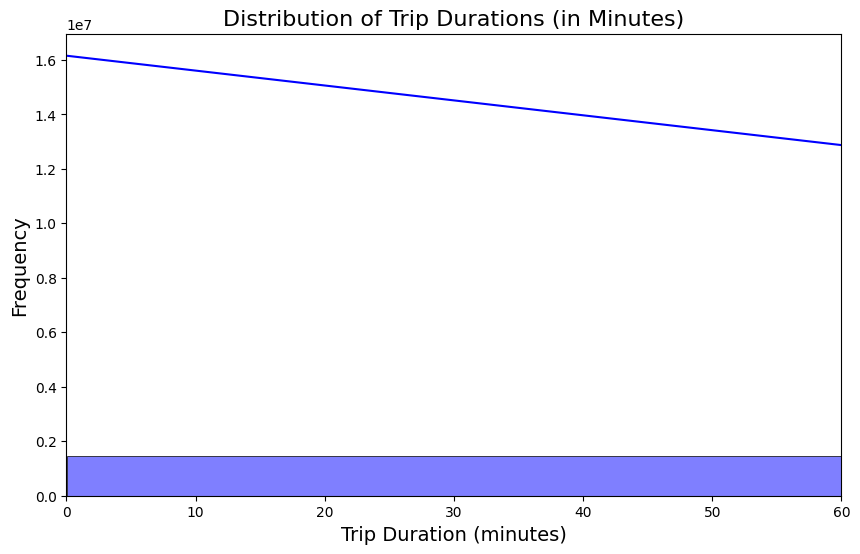

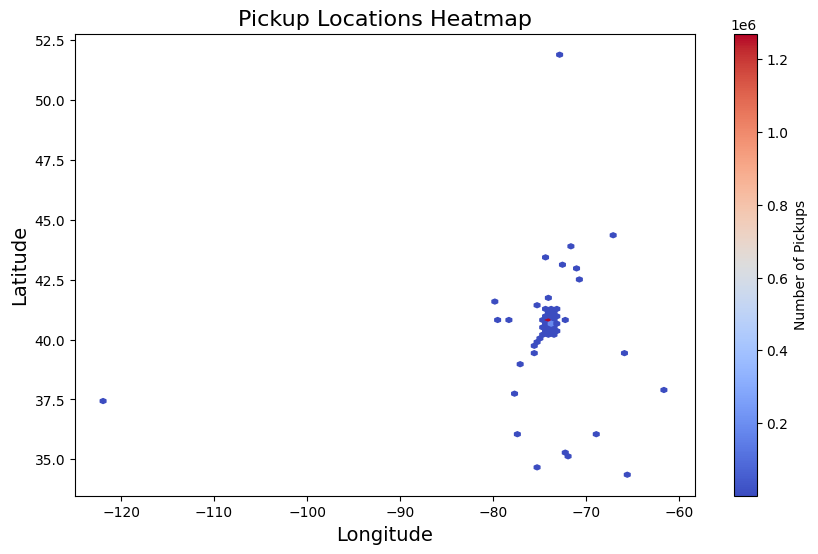

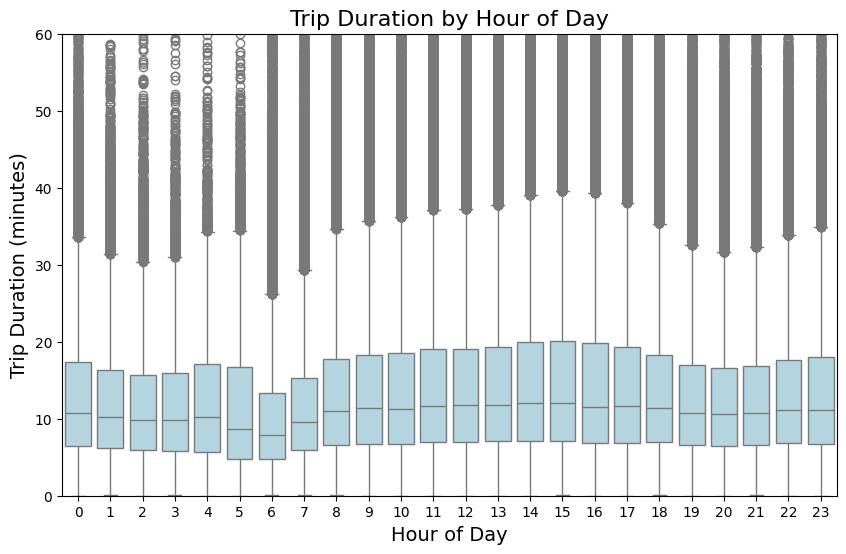

<ipython-input-5-bfb4491da71a>:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='pickup_day_of_week', y='trip_duration_minutes', data=p_df, palette='pastel')


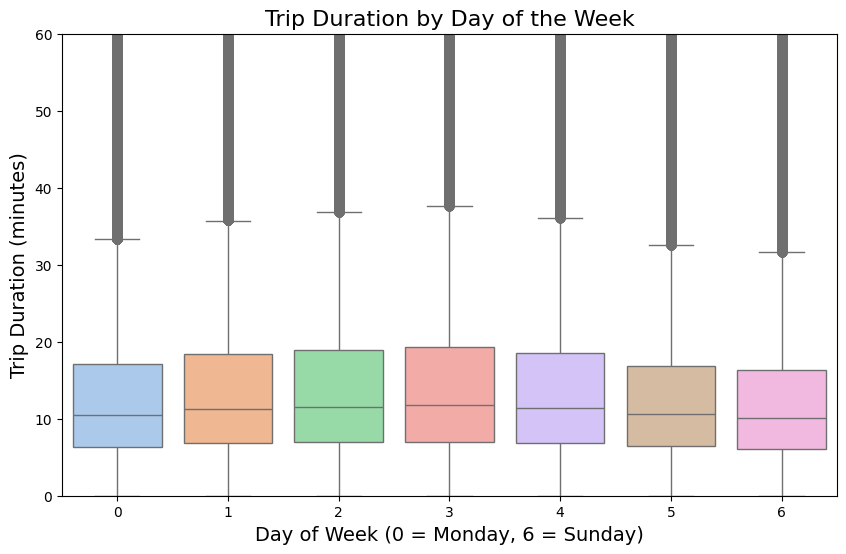

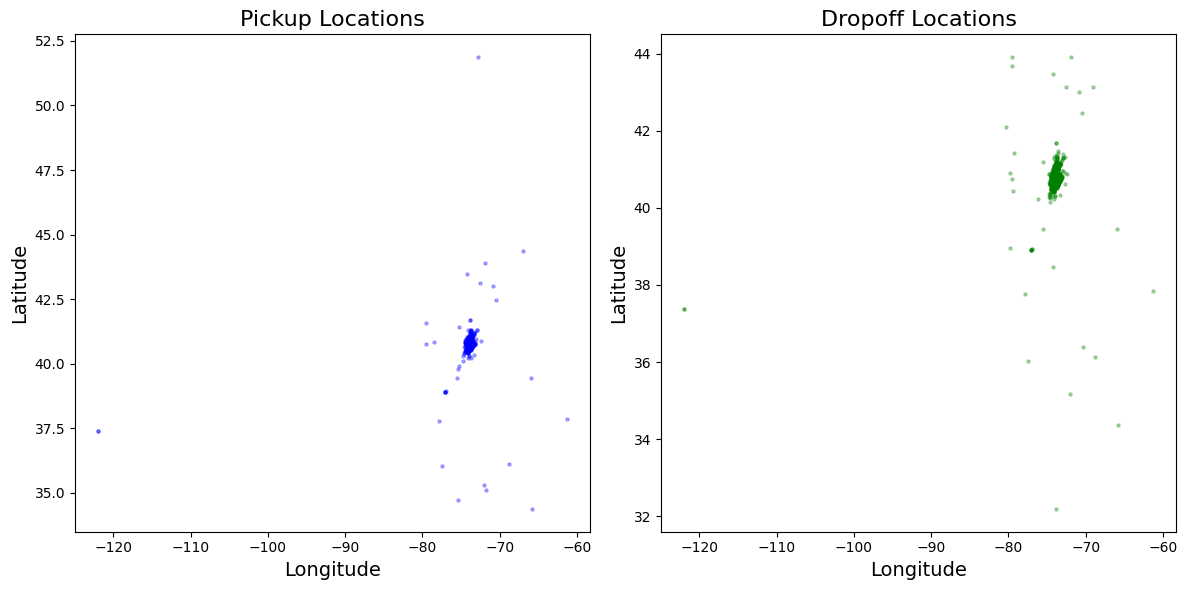

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the dataset from URL
url = "https://project4-nyctaxi.s3.us-east-1.amazonaws.com/train.csv"
p_df = pd.read_csv(url)

# Convert datetime columns
p_df['pickup_datetime'] = pd.to_datetime(p_df['pickup_datetime'])
p_df['dropoff_datetime'] = pd.to_datetime(p_df['dropoff_datetime'])

# Extract new features for analysis
p_df['trip_duration_minutes'] = p_df['trip_duration'] / 60  # Convert trip duration to minutes
p_df['pickup_hour'] = p_df['pickup_datetime'].dt.hour
p_df['pickup_day_of_week'] = p_df['pickup_datetime'].dt.dayofweek
p_df['pickup_month'] = p_df['pickup_datetime'].dt.month

# Visualization 1: Trip Duration Distribution
plt.figure(figsize=(10, 6))
sns.histplot(p_df['trip_duration_minutes'], bins=100, kde=True, color='blue')
plt.title('Distribution of Trip Durations (in Minutes)', fontsize=16)
plt.xlabel('Trip Duration (minutes)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xlim(0, 60)  # Focus on trips up to 60 minutes for better visualization
plt.show()

# Visualization 2: Pickup Locations Heatmap
plt.figure(figsize=(10, 6))
plt.hexbin(p_df['pickup_longitude'], p_df['pickup_latitude'], gridsize=100, cmap='coolwarm', mincnt=1)
plt.colorbar(label='Number of Pickups')
plt.title('Pickup Locations Heatmap', fontsize=16)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)
plt.show()

# Visualization 3: Trip Duration by Hour of Day
plt.figure(figsize=(10, 6))
sns.boxplot(x='pickup_hour', y='trip_duration_minutes', data=p_df, color='lightblue')
plt.title('Trip Duration by Hour of Day', fontsize=16)
plt.xlabel('Hour of Day', fontsize=14)
plt.ylabel('Trip Duration (minutes)', fontsize=14)
plt.ylim(0, 60)  # Focus on trips up to 60 minutes
plt.show()

# Visualization 4: Trip Duration by Day of Week
plt.figure(figsize=(10, 6))
sns.boxplot(x='pickup_day_of_week', y='trip_duration_minutes', data=p_df, palette='pastel')
plt.title('Trip Duration by Day of the Week', fontsize=16)
plt.xlabel('Day of Week (0 = Monday, 6 = Sunday)', fontsize=14)
plt.ylabel('Trip Duration (minutes)', fontsize=14)
plt.ylim(0, 60)  # Focus on trips up to 60 minutes
plt.show()

# Visualization 5: Pickup vs. Dropoff Locations
plt.figure(figsize=(12, 6))

# Subplot 1: Pickup locations
plt.subplot(1, 2, 1)
plt.scatter(p_df['pickup_longitude'], p_df['pickup_latitude'], alpha=0.3, s=5, color='blue')
plt.title('Pickup Locations', fontsize=16)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)

# Subplot 2: Dropoff locations
plt.subplot(1, 2, 2)
plt.scatter(p_df['dropoff_longitude'], p_df['dropoff_latitude'], alpha=0.3, s=5, color='green')
plt.title('Dropoff Locations', fontsize=16)
plt.xlabel('Longitude', fontsize=14)
plt.ylabel('Latitude', fontsize=14)

plt.tight_layout()
plt.show()


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Training XGBoost Regressor...
XGBoost Regressor Results:
  RMSE: 304.70
  R²: 0.73
------------------------------


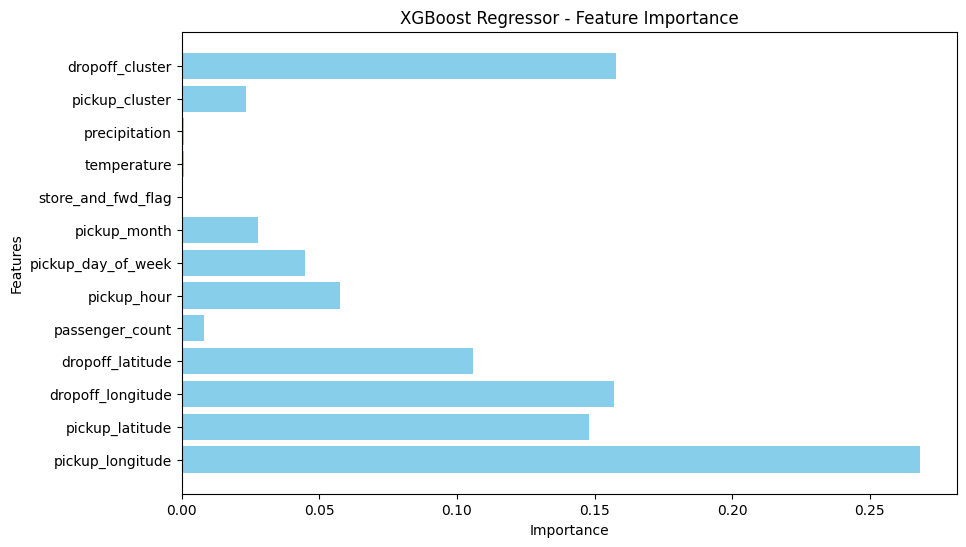

Training LightGBM Regressor...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.344579 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1590
[LightGBM] [Info] Number of data points in the train set: 1150185, number of used features: 13
[LightGBM] [Info] Start training from score 816.478285
LightGBM Regressor Results:
  RMSE: 297.48
  R²: 0.74
------------------------------


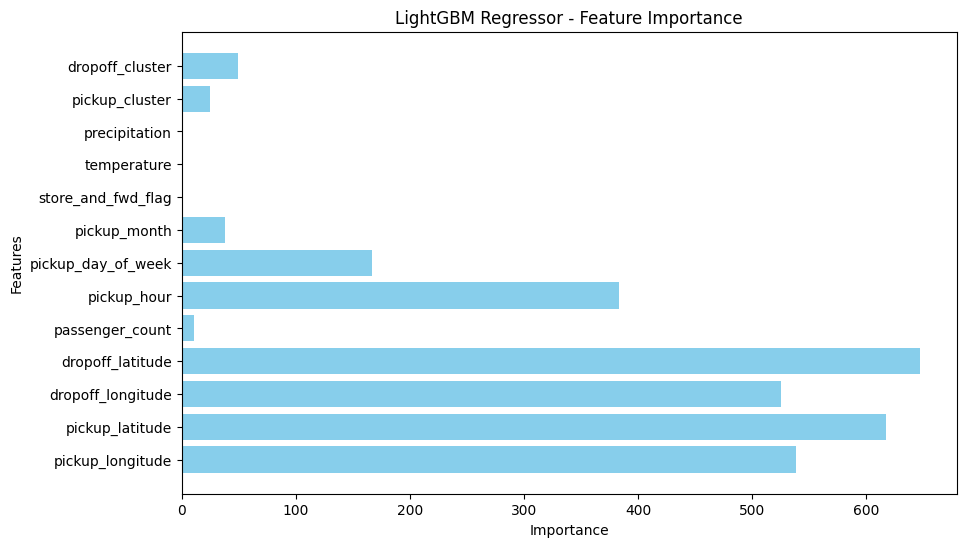

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Load the dataset from URL
url = "https://project4-nyctaxi.s3.us-east-1.amazonaws.com/train.csv"
p_df = pd.read_csv(url)

# Feature Engineering
p_df['pickup_datetime'] = pd.to_datetime(p_df['pickup_datetime'])
p_df['dropoff_datetime'] = pd.to_datetime(p_df['dropoff_datetime'])

# Extract datetime features
p_df['pickup_hour'] = p_df['pickup_datetime'].dt.hour
p_df['pickup_day_of_week'] = p_df['pickup_datetime'].dt.dayofweek
p_df['pickup_month'] = p_df['pickup_datetime'].dt.month

# Encode 'store_and_fwd_flag'
label_encoder = LabelEncoder()
p_df['store_and_fwd_flag'] = label_encoder.fit_transform(p_df['store_and_fwd_flag'])

# Simulate weather data (for demonstration purposes)
np.random.seed(42)
p_df['temperature'] = np.random.uniform(30, 100, size=len(p_df))  # Simulated temperature in Fahrenheit
p_df['precipitation'] = np.random.uniform(0, 1, size=len(p_df))  # Simulated precipitation (inches)

# Geospatial clustering for pickup and dropoff points
pickup_coords = p_df[['pickup_latitude', 'pickup_longitude']].to_numpy()
dropoff_coords = p_df[['dropoff_latitude', 'dropoff_longitude']].to_numpy()

# K-Means Clustering
kmeans_pickup = KMeans(n_clusters=5, random_state=42).fit(pickup_coords)
kmeans_dropoff = KMeans(n_clusters=5, random_state=42).fit(dropoff_coords)

p_df['pickup_cluster'] = kmeans_pickup.labels_
p_df['dropoff_cluster'] = kmeans_dropoff.labels_

# Filter outliers in trip duration (e.g., trips shorter than 1 min or longer than 1 hour)
p_df = p_df[(p_df['trip_duration'] >= 60) & (p_df['trip_duration'] <= 3600)]

# Features and target variable
features = [
    'pickup_longitude', 'pickup_latitude',
    'dropoff_longitude', 'dropoff_latitude',
    'passenger_count', 'pickup_hour',
    'pickup_day_of_week', 'pickup_month',
    'store_and_fwd_flag', 'temperature',
    'precipitation', 'pickup_cluster',
    'dropoff_cluster'
]
X = p_df[features]
y = p_df['trip_duration']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Models
models = {
    'XGBoost Regressor': XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    'LightGBM Regressor': LGBMRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
}

# Train and Evaluate Models
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print(f"{name} Results:")
    print(f"  RMSE: {rmse:.2f}")
    print(f"  R²: {r2:.2f}")
    print("-" * 30)

    # Plot Feature Importance
    if hasattr(model, "feature_importances_"):
        importance = model.feature_importances_
        plt.figure(figsize=(10, 6))
        plt.barh(features, importance, color='skyblue')
        plt.xlabel("Importance")
        plt.ylabel("Features")
        plt.title(f"{name} - Feature Importance")
        plt.show()


          id  vendor_id      pickup_datetime     dropoff_datetime  \
0  id2875421          2  2016-03-14 17:24:55  2016-03-14 17:32:30   
1  id2377394          1  2016-06-12 00:43:35  2016-06-12 00:54:38   
2  id3858529          2  2016-01-19 11:35:24  2016-01-19 12:10:48   
3  id3504673          2  2016-04-06 19:32:31  2016-04-06 19:39:40   
4  id2181028          2  2016-03-26 13:30:55  2016-03-26 13:38:10   

   passenger_count  pickup_longitude  pickup_latitude  dropoff_longitude  \
0                1        -73.982155        40.767937         -73.964630   
1                1        -73.980415        40.738564         -73.999481   
2                1        -73.979027        40.763939         -74.005333   
3                1        -74.010040        40.719971         -74.012268   
4                1        -73.973053        40.793209         -73.972923   

   dropoff_latitude store_and_fwd_flag  trip_duration  
0         40.765602                  N            455  
1         40.731

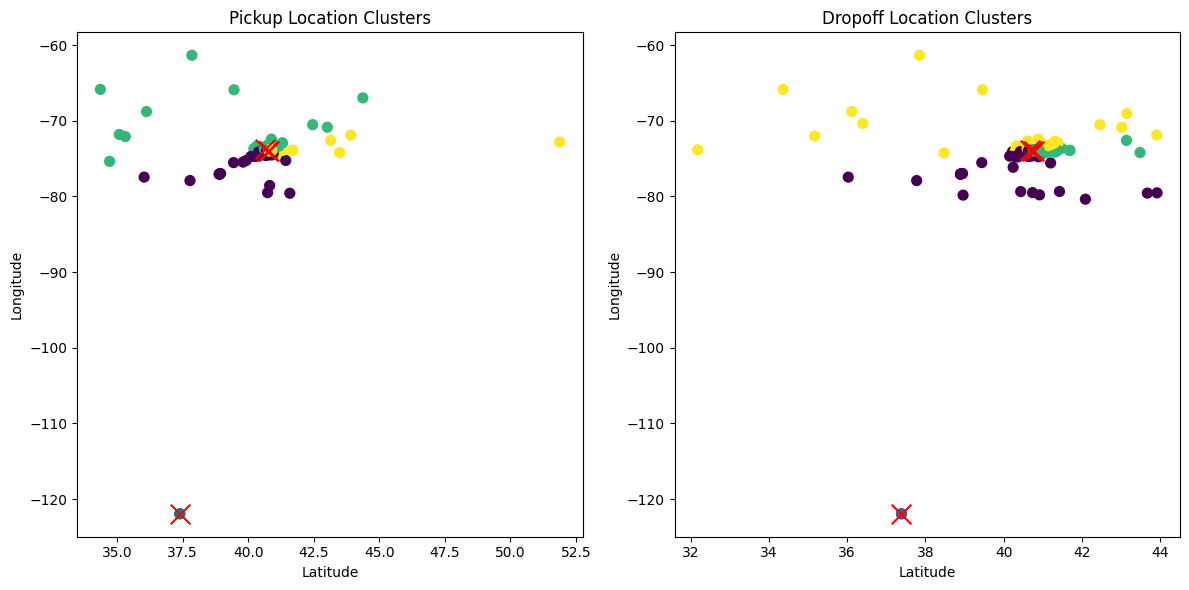

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# URL for the dataset
url = "https://project4-nyctaxi.s3.us-east-1.amazonaws.com/train.csv"

# Load the dataset into a Pandas DataFrame
df = pd.read_csv(url)

# Display the first few rows of the dataframe
print(df.head())

# Extract coordinates for clustering
pickup_coords = df[['pickup_latitude', 'pickup_longitude']].to_numpy()
dropoff_coords = df[['dropoff_latitude', 'dropoff_longitude']].to_numpy()

# K-means clustering
n_clusters = 4  # Updated number of clusters
kmeans_pickup = KMeans(n_clusters=n_clusters, random_state=42).fit(pickup_coords)
kmeans_dropoff = KMeans(n_clusters=n_clusters, random_state=42).fit(dropoff_coords)

# Add cluster labels back to the dataframe
df['pickup_cluster'] = kmeans_pickup.labels_
df['dropoff_cluster'] = kmeans_dropoff.labels_

# Visualize the clusters
plt.figure(figsize=(12, 6))

# Plot pickup clusters
plt.subplot(1, 2, 1)
plt.scatter(pickup_coords[:, 0], pickup_coords[:, 1], c=kmeans_pickup.labels_, cmap='viridis', s=50)
plt.scatter(kmeans_pickup.cluster_centers_[:, 0], kmeans_pickup.cluster_centers_[:, 1], color='red', marker='x', s=200)
plt.title('Pickup Location Clusters')
plt.xlabel('Latitude')
plt.ylabel('Longitude')

# Plot dropoff clusters
plt.subplot(1, 2, 2)
plt.scatter(dropoff_coords[:, 0], dropoff_coords[:, 1], c=kmeans_dropoff.labels_, cmap='viridis', s=50)
plt.scatter(kmeans_dropoff.cluster_centers_[:, 0], kmeans_dropoff.cluster_centers_[:, 1], color='red', marker='x', s=200)
plt.title('Dropoff Location Clusters')
plt.xlabel('Latitude')
plt.ylabel('Longitude')

plt.tight_layout()
plt.show()


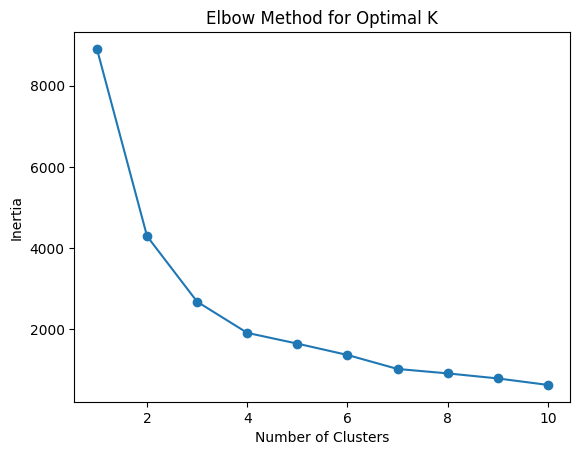

In [8]:
inertias = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42).fit(pickup_coords)
    inertias.append(kmeans.inertia_)

plt.plot(range(1, 11), inertias, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()


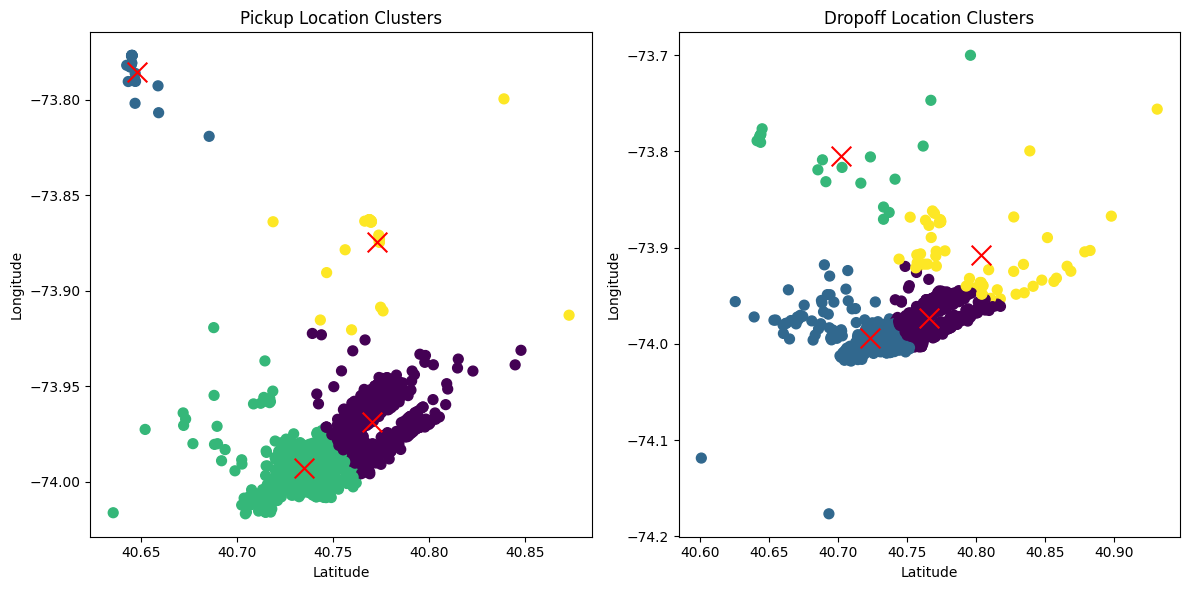

In [8]:
import pandas as pd
import folium
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# URL for the dataset
url = "https://project4-nyctaxi.s3.us-east-1.amazonaws.com/train.csv"

# Load the dataset into a Pandas DataFrame
df = pd.read_csv(url)

# Limit the dataset to 1000 random rows
df = df.sample(1000, random_state=42)

# Extract coordinates for clustering
pickup_coords = df[['pickup_latitude', 'pickup_longitude']].to_numpy()
dropoff_coords = df[['dropoff_latitude', 'dropoff_longitude']].to_numpy()

# K-means clustering with 4 clusters
n_clusters = 4
kmeans_pickup = KMeans(n_clusters=n_clusters, random_state=42).fit(pickup_coords)
kmeans_dropoff = KMeans(n_clusters=n_clusters, random_state=42).fit(dropoff_coords)

# Add cluster labels back to the dataframe
df['pickup_cluster'] = kmeans_pickup.labels_
df['dropoff_cluster'] = kmeans_dropoff.labels_

# Create a plot for the pickup clusters
plt.figure(figsize=(12, 6))

# Plot pickup clusters
plt.subplot(1, 2, 1)
plt.scatter(pickup_coords[:, 0], pickup_coords[:, 1], c=kmeans_pickup.labels_, cmap='viridis', s=50)
plt.scatter(kmeans_pickup.cluster_centers_[:, 0], kmeans_pickup.cluster_centers_[:, 1], color='red', marker='x', s=200)
plt.title('Pickup Location Clusters')
plt.xlabel('Latitude')
plt.ylabel('Longitude')

# Plot dropoff clusters
plt.subplot(1, 2, 2)
plt.scatter(dropoff_coords[:, 0], dropoff_coords[:, 1], c=kmeans_dropoff.labels_, cmap='viridis', s=50)
plt.scatter(kmeans_dropoff.cluster_centers_[:, 0], kmeans_dropoff.cluster_centers_[:, 1], color='red', marker='x', s=200)
plt.title('Dropoff Location Clusters')
plt.xlabel('Latitude')
plt.ylabel('Longitude')

plt.tight_layout()
plt.show()

# Create a Folium map centered around NYC
nyc_map = folium.Map(location=[40.7128, -74.0060], zoom_start=12, tiles="CartoDB positron")

# Define a color palette for clusters
colors = ['red', 'blue', 'green', 'purple']

# Add pickup clusters to the map
for _, row in df.iterrows():
    folium.CircleMarker(
        location=(row['pickup_latitude'], row['pickup_longitude']),
        radius=4,
        color=colors[row['pickup_cluster']],
        fill=True,
        fill_opacity=0.6,
        popup=f"Pickup Cluster: {row['pickup_cluster']}"
    ).add_to(nyc_map)

# Add dropoff clusters to the map
for _, row in df.iterrows():
    folium.CircleMarker(
        location=(row['dropoff_latitude'], row['dropoff_longitude']),
        radius=4,
        color=colors[row['dropoff_cluster']],
        fill=True,
        fill_opacity=0.6,
        popup=f"Dropoff Cluster: {row['dropoff_cluster']}"
    ).add_to(nyc_map)

# Add cluster centers for pickups
for i, center in enumerate(kmeans_pickup.cluster_centers_):
    folium.Marker(
        location=(center[0], center[1]),
        icon=folium.Icon(color='black', icon='info-sign'),
        popup=f"Pickup Cluster Center {i}"
    ).add_to(nyc_map)

# Add cluster centers for dropoffs
for i, center in enumerate(kmeans_dropoff.cluster_centers_):
    folium.Marker(
        location=(center[0], center[1]),
        icon=folium.Icon(color='orange', icon='info-sign'),
        popup=f"Dropoff Cluster Center {i}"
    ).add_to(nyc_map)

# Save the map to an HTML file and open it in the browser
file_path = "nyc_taxi_clusters_with_map.html"
nyc_map.save(file_path)

# For Google Colab: Open the map in the browser
from google.colab.output import eval_js
eval_js(f'window.open("{file_path}", "_blank")')
